## Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

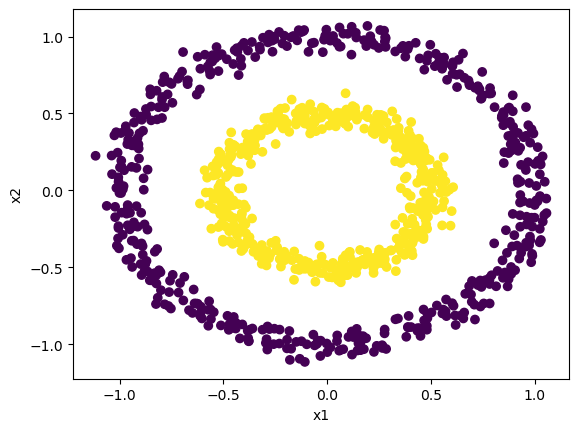

In [2]:
# mock datasets
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

## Dataloader

In [5]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

In [6]:
class OurDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
ds_train = OurDataset(X_train, y_train)  # 创建训练集实例
for v in ds_train:
    print(v)
    break

(tensor([ 0.4413, -0.2603]), tensor(1.))


In [8]:
for v in DataLoader(ds_train, batch_size=2, shuffle=True):
    print(v)
    break

[tensor([[ 0.2356,  0.4174],
        [-0.2217, -0.4524]]), tensor([1., 1.])]


## PyTorch

### Model

In [9]:
import torch
import torch.nn as nn

import torch.nn.functional as F

In [10]:
class TorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.stack = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits

In [11]:
model = TorchModel()
model

TorchModel(
  (stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [12]:
logits=model(v[0])

### Loss Function

In [13]:
print(v)

[tensor([[ 0.2356,  0.4174],
        [-0.2217, -0.4524]]), tensor([1., 1.])]


In [14]:
print(v[1])

tensor([1., 1.])


In [15]:
print( v[1].view(-1, 1))

tensor([[1.],
        [1.]])


In [16]:
print(logits)

tensor([[ 0.0595],
        [-0.1432]], grad_fn=<AddmmBackward0>)


In [17]:
# Sigmoid + BCELoss
loss_fn = nn.BCEWithLogitsLoss()

In [18]:
loss_fn(logits, v[1].view(-1, 1))

tensor(0.7156, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

### Optimizer

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Training

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print("size=",size)
    model.train()
    for idx, (X, y) in enumerate(dataloader, start=1):
        X, y = X.to(device), y.to(device)

        # 前向
        logits = model(X)
        loss = loss_fn(logits, y.view(-1, 1))

        # 反向
        model.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 50 == 0:
            loss, current = loss.item(), idx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            test_loss += loss_fn(logits, y.view(-1, 1)).item()
            pred = F.sigmoid(logits)
            output = (pred > 0.5).float()
            correct += (output == y.view(-1, 1)).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Training with PyTorch Model on {device} \n")

BATCH_SIZE = 4
ds_train = OurDataset(X_train, y_train)
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
ds_test = OurDataset(X_test, y_test)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

model = TorchModel().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

NUM_EPOCHS = 3

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch: {epoch}")
    train(dl_train, model, loss_fn, optimizer)
    test(dl_test, model, loss_fn)

Training with PyTorch Model on cpu 

Epoch: 1
size= 800
loss: 0.672230  [  200/  800]
loss: 0.603602  [  400/  800]
loss: 0.573251  [  600/  800]
loss: 0.568909  [  800/  800]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.553781 

Epoch: 2
size= 800
loss: 0.454966  [  200/  800]
loss: 0.439495  [  400/  800]
loss: 0.335823  [  600/  800]
loss: 0.381780  [  800/  800]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.362987 

Epoch: 3
size= 800
loss: 0.235428  [  200/  800]
loss: 0.257548  [  400/  800]
loss: 0.207918  [  600/  800]
loss: 0.271786  [  800/  800]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.210559 



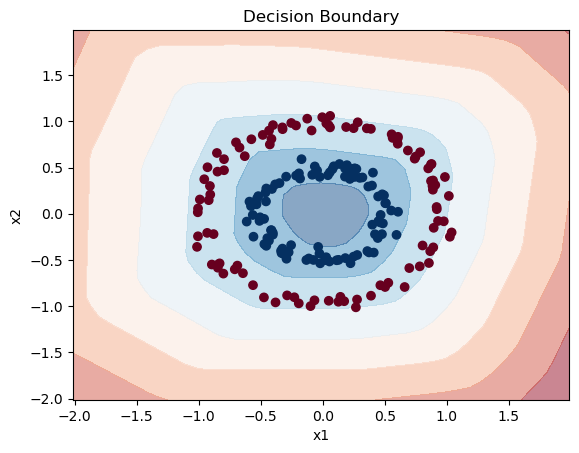

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    h = .1  # 步长

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), 
        np.arange(y_min, y_max, h)
    )
    
    Z = model(torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device))
    Z = Z.cpu().detach().numpy().reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary(X_test, y_test, model, title="Decision Boundary")

## Hands-on

### Model

In [24]:
class HandsonModel:

    def __init__(self, input_size: int = 2, hidden_size: int = 32, output_size: int = 1):
        self.w1 = np.random.randn(input_size, hidden_size) * 0.01 # i,h
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * 0.01 # h,o
        self.b2 = np.zeros((1, output_size))
        self.p = {}

    def forward(self, x):
        z1 = x @ self.w1 + self.b1 # b,i x i,h = > b,h
        a1 = relu(z1)
        z2 = a1 @ self.w2 + self.b2 # b,h x h,o => b,o
        self.p["x"] = x
        self.p["z1"] = z1
        self.p["a1"] = a1
        self.p["z2"] = z2
        return z2

    def __call__(self, x):
        return self.forward(x)

    def backward(self, y):
        n = self.p["x"].shape[0]
        pred = sigmoid(self.p["z2"])  # b,o
        err = pred - y # b,o
        print("backward(self, y)")
        print('self.p["z2"]',self.p["z2"])
        print(f'y={y},n={n},pred={pred},err={err}')
        
        dz2 = err * deri_sigmoid(pred) # b,o
        dw2 = (self.p["a1"].T @ dz2) / n # h,b x b,o => h,o
        db2 = np.sum(dz2, axis=0, keepdims=True) / n
        print(f'deri_sigmoid(pred)={deri_sigmoid(pred)},dz2={dz2},dw2={dw2},db2={db2}')
        
        dz1 = (dz2 @ self.w2.T) * deri_relu(self.p["z1"]) # b,o x o,h => b,h
        dw1 = (self.p["x"].T @ dz1) / n  # i,b x b,h => i,h
        db1 = np.sum(dz1, axis=0, keepdims=True) / n
        print(f'dz1={dz1},dw1={dw1},db1={db1}')
        
        self.p["dw1"] = dw1
        self.p["db1"] = db1
        self.p["dw2"] = dw2
        self.p["db2"] = db2

    def step(self, lr: float):
        self.w1 -= lr * self.p["dw1"]
        self.b1 -= lr * self.p["db1"]
        self.w2 -= lr * self.p["dw2"]
        self.b2 -= lr * self.p["db2"]

### Loss

$$ \text{BCE} = −(y \log (p) + (1−y) \log (1−p))$$

In [25]:
def relu(z):
    return np.maximum(0, z)

def deri_relu(z):
    return (z > 0) * 1.0

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def deri_sigmoid(z):
    return z * (1 - z)

def compute_loss(logits, y):
    y_pred = sigmoid(logits)
    m = y.shape[0]
    loss = y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)
    return -loss.mean()

### Training

In [26]:
def train(dataloader, model, lr):
    size = len(dataloader.dataset)
    for idx, (X, y) in enumerate(dataloader, start=1):
        X = X.numpy()
        y = y.numpy()
        logits = model(X)
        loss = compute_loss(logits, y.reshape(-1, 1))
        model.backward(y.reshape(-1, 1))
        model.step(lr=lr)
        
        if idx % 50 == 0:
            print("logits=",logits)
            print("loss=",loss)
            #print("y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)=",y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
            print("1 * np.log(0.4)=",1 * np.log(0.4))
            print("1 * np.log(0.8)=",1 * np.log(0.8))
            print("(1 - y) * np.log(1 - y_pred)=",(1 - 1) * np.log(1 - 0.4))
            print("y=",y)
            print("y.reshape(-1, 1)=",y.reshape(-1, 1))
            loss, current = loss, idx * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    for X, y in dataloader:
        X = X.numpy()
        y = y.numpy()
        logits = model(X)
        test_loss += compute_loss(logits, y.reshape(-1, 1))
        
        pred = sigmoid(logits)
        output = (pred > 0.5).astype(np.float32)
        correct += (output == y.reshape(-1, 1)).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [27]:
BATCH_SIZE = 4
ds_train = OurDataset(X_train, y_train)
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
ds_test = OurDataset(X_test, y_test)
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)


model = HandsonModel()
NUM_EPOCHS = 3

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch: {epoch}")
    train(dl_train, model, 1.2)
    test(dl_test, model)

Epoch: 1
backward(self, y)
self.p["z2"] [[-0.00052213]
 [-0.00019649]
 [-0.00069881]
 [-0.00045655]]
y=[[0.]
 [1.]
 [0.]
 [0.]],n=4,pred=[[0.49986947]
 [0.49995088]
 [0.4998253 ]
 [0.49988586]],err=[[ 0.49986947]
 [-0.50004912]
 [ 0.4998253 ]
 [ 0.49988586]]
deri_sigmoid(pred)=[[0.24999998]
 [0.25      ]
 [0.24999997]
 [0.24999999]],dz2=[[ 0.12496736]
 [-0.12501228]
 [ 0.12495631]
 [ 0.12497146]],dw2=[[ 6.33823606e-04]
 [ 2.15044976e-04]
 [ 1.84819846e-04]
 [ 3.02376245e-04]
 [ 1.55135384e-04]
 [ 1.33331642e-05]
 [ 4.35466391e-04]
 [ 3.36172627e-04]
 [ 1.01874126e-04]
 [ 7.49150828e-04]
 [ 8.40711128e-05]
 [ 8.86487267e-05]
 [ 7.54121812e-04]
 [ 1.12393376e-03]
 [ 5.13734456e-04]
 [ 3.11005985e-04]
 [ 2.25928230e-04]
 [ 1.53580818e-04]
 [ 8.60176727e-05]
 [ 1.96464091e-04]
 [ 1.12775616e-03]
 [ 0.00000000e+00]
 [-7.85618120e-06]
 [ 8.02857001e-04]
 [ 5.83415585e-05]
 [ 3.51181865e-04]
 [ 2.06267699e-04]
 [ 3.81051511e-04]
 [ 7.56761081e-04]
 [ 3.02148393e-04]
 [-3.36622466e-05]
 [ 4.32

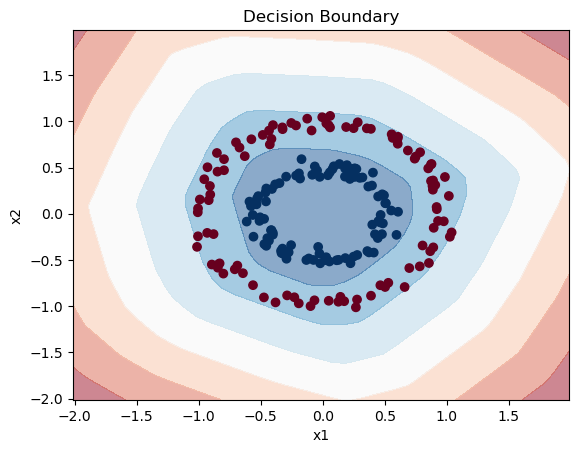

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, title="Decision Boundary"):
    h = .1  # 步长

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h), 
        np.arange(y_min, y_max, h)
    )
    
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_boundary(X_test, y_test, model, title="Decision Boundary")

参考资料：

- [Datasets & DataLoaders — PyTorch Tutorials 2.2.0+cu121 documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)
- [Training with PyTorch — PyTorch Tutorials 2.2.0+cu121 documentation](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)
- [Quickstart — PyTorch Tutorials 2.2.0+cu121 documentation](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)